# Import Libraries

In [55]:

import pandas   # data manipulation
import os       # file system operations    
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt # plotting
import random  # random number generation

# Download Dataset

In [47]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("borismarjanovic/price-volume-data-for-all-us-stocks-etfs")

print("Path to dataset files:", path)

# path to stocks only:
path = path + "/Stocks/"

print(f"There are {len(os.listdir(path))} stocks in the dataset")

Path to dataset files: /Users/z003zckm/.cache/kagglehub/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/versions/3
There are 7195 stocks in the dataset


# Preprocess Data

In [63]:
# load all symbols in ./../data/sample1
symbols = []
for file in os.listdir(path):
    # check if file is a csv by content
    try:
        df = pandas.read_csv(path + f"/{file}")
        symbols.append(df)
    except:
        print(f"Skipping {file}")

Skipping pbio.us.txt
Skipping accp.us.txt
Skipping amrh.us.txt
Skipping vist.us.txt
Skipping srva.us.txt
Skipping bbrx.us.txt
Skipping bolt.us.txt
Skipping amrhw.us.txt
Skipping znwaa.us.txt
Skipping stnl.us.txt
Skipping hayu.us.txt
Skipping otg.us.txt
Skipping molc.us.txt
Skipping boxl.us.txt
Skipping sbt.us.txt
Skipping fmax.us.txt
Skipping rbio.us.txt
Skipping wnfm.us.txt
Skipping jt.us.txt
Skipping pxus.us.txt
Skipping vmet.us.txt
Skipping asns.us.txt
Skipping sfix.us.txt
Skipping scci.us.txt
Skipping sail.us.txt
Skipping wspt.us.txt
Skipping scph.us.txt
Skipping gnst.us.txt
Skipping send.us.txt
Skipping bxg.us.txt
Skipping mapi.us.txt
Skipping ehr.us.txt


In [64]:

# Data schema
# Date	Open	High	Low	Close	Volume	OpenInt
# 0	1970-01-02	2.2972	2.3178	2.2972	2.2972	26437	0
# 1	1970-01-05	2.2972	2.2972	2.2544	2.2759	29887	0
# 2	1970-01-06	2.2759	2.2759	2.2342	2.2342	106900	0
# 3	1970-01-07	2.2342	2.2342	2.2342	2.2342	85061	0
# 4	1970-01-08	2.2342	2.2342	2.2139	2.2139	66669	0

# for all symbols compute the average price (high + low) / 2 and add as column
for df in symbols:
    df['AvgPrice'] = (df['High'] + df['Low']) / 2
    
# compute a common "time index" by finding first and last date and then map all dates to a number
first_date = min([min(df['Date']) for df in symbols])
last_date = max([max(df['Date']) for df in symbols])

# create a dictionary that maps dates to numbers
date_to_num = {}
num_to_date = {}
for idx, date in enumerate(pandas.date_range(first_date, last_date)):
    date_to_num[date] = idx
    num_to_date[idx] = date
    
# drop all columns but the  Date and AvgPrice columns
all_columns = df.columns
columns_to_keep = ['Date', 'AvgPrice']
columns_to_drop = [col for col in all_columns if col not in columns_to_keep]


# add the index to the dataframes
for idx, df in enumerate(tqdm(symbols)):
    # drop all columns but the  Date and AvgPrice columns
    df.drop(columns=columns_to_drop, inplace=True)
    
    # add the index
    df.loc[:, 'timeindex'] = df['Date'].map(date_to_num)    


100%|██████████| 7163/7163 [01:47<00:00, 66.64it/s]


In [65]:
symbols[0].tail()

,Date,AvgPrice,timeindex
3194,2017-11-06,58.7875,20397
3195,2017-11-07,58.8650,20398
3196,2017-11-08,58.8325,20399
3197,2017-11-09,58.8350,20400
3198,2017-11-10,58.5800,20401


Create time slices: For example, we could work on slices of 1 year. Other slices are conceivable. It's important to only work with the symbols that are fully available in the slice.

In [75]:
# compute the slices
# from the last available time slot go back 350 days. The last remaning slot does not need to have 350 days. Then create a list with the index of the slice and the start and end index of the slice.
slices = []
max_index = max(num_to_date.keys())
# partition the data into slices of 350 days
for end in range(max_index, 0, -350):
    start = end - 350
    if start < 0:
        start = 0
    slices.append((start, end))


In [77]:
from tqdm import tqdm

# For every slice compute the available symbols (checking if the min and max timeindex is within the slice)

slice_availability = []
for idx, (start, end) in tqdm(enumerate(slices), total=len(slices), desc="Slices"):
    available_symbols = []
    for idx, df in tqdm(enumerate(symbols), total=len(symbols), desc=f"Symbols in slice {idx}", leave=False):
        if min(df['timeindex']) <= start and max(df['timeindex']) >= end:
            available_symbols.append(idx)
    slice_availability.append(available_symbols)


Slices: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it]


In [88]:
len(slice_availability[55])

2

In [89]:
# Slice with the most symbols
max_symbols = max([len(s) for s in slice_availability])
# index of the slice with the most symbols
max_symbols_slice = [idx for idx, s in enumerate(slice_availability) if len(s) == max_symbols][0]
print(f"Slice with most symbols is {max_symbols_slice} with {max_symbols} symbols")

Slice with most symbols is 0 with 6084 symbols


In [95]:
random.seed(42)
symbols_selected_idx = random.sample(slice_availability[max_symbols_slice], 10)
print(f"Slice Window: start: {num_to_date[slices[max_symbols_slice][0]]}, end: {num_to_date[slices[max_symbols_slice][1]]}")
for idx in symbols_selected_idx:
    print(f"Symbol {idx}: start: {num_to_date[min(symbols[idx]['timeindex'])]}, end: {num_to_date[max(symbols[idx]['timeindex'])]}")

Slice Window: start: 2016-11-25 00:00:00, end: 2017-11-10 00:00:00
Symbol 6165: start: 2005-02-25 00:00:00, end: 2017-11-10 00:00:00
Symbol 1070: start: 1977-01-03 00:00:00, end: 2017-11-10 00:00:00
Symbol 244: start: 2005-02-25 00:00:00, end: 2017-11-10 00:00:00
Symbol 7153: start: 2010-02-23 00:00:00, end: 2017-11-10 00:00:00
Symbol 2640: start: 2014-12-10 00:00:00, end: 2017-11-10 00:00:00
Symbol 2349: start: 1980-01-02 00:00:00, end: 2017-11-10 00:00:00
Symbol 2142: start: 2016-10-28 00:00:00, end: 2017-11-10 00:00:00
Symbol 1337: start: 2005-02-25 00:00:00, end: 2017-11-10 00:00:00
Symbol 7109: start: 2005-02-25 00:00:00, end: 2017-11-10 00:00:00
Symbol 981: start: 2014-12-19 00:00:00, end: 2017-11-10 00:00:00


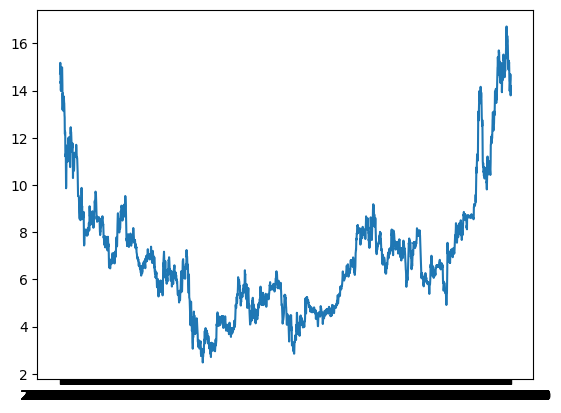

In [97]:
# plot symbol 6165
symbol = symbols[6165]
plt.plot(symbol['Date'], symbol[f'AvgPrice'], label=f'Symbol_{idx}')
plt.show()

# Visualize Dataset (and some descriptive statistics)

<Figure size 640x480 with 0 Axes>

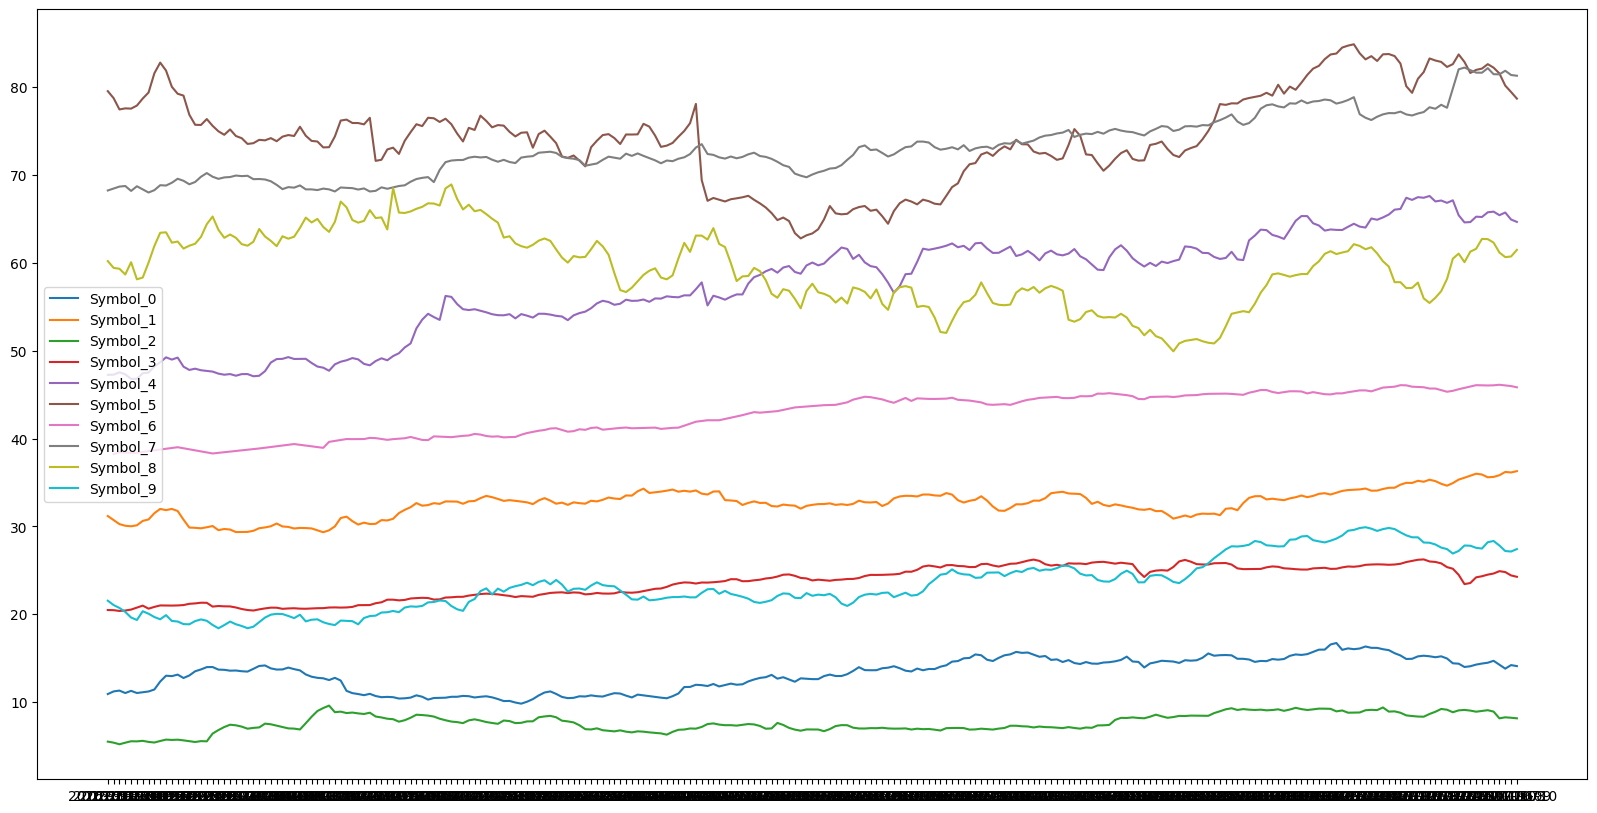

In [98]:
# choose slice
slice_idx = max_symbols_slice

# clear old plot
plt.clf()

# plot all symbols in a single chart
plt.figure(figsize=(20, 10))

# randomly select 10 symbols
random.seed(42)
symbols_selected_idx = random.sample(slice_availability[slice_idx], 10)

for idx, symbol_to_plot in enumerate(symbols_selected_idx):
    symbol = symbols[symbol_to_plot]
    # slice to the selected slice
    symbol = symbol[(symbol['timeindex'] >= slices[slice_idx][0]) & (symbol['timeindex'] <= slices[slice_idx][1])]
    # use the Date as x-axis and the AvgPrice as y-axis
    plt.plot(symbol['Date'], symbol[f'AvgPrice'], label=f'Symbol_{idx}')
plt.legend()
plt.show()

# Detect clusters

In [ ]:
# Compute a dendrogram of the symbols

/var/folders/tz/x9zmsny551557y_7gwtsbhgw0000gn/T/ipykernel_33188/1913854209.py:22: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')  # You can choose other methods like 'average', 'single', etc.


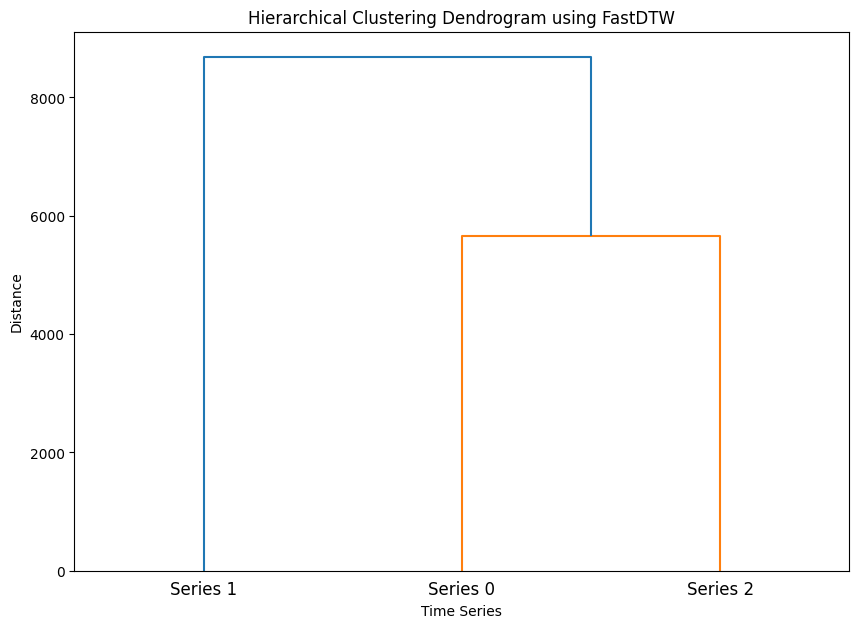

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.cluster.hierarchy import linkage, dendrogram

# Generate synthetic time series data
time_series_data = df_all_symbols

# Compute the distance matrix using FastDTW
n = len(symbols)
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            distance, _ = fastdtw(time_series_data[f'AvgPrice_{i}'], time_series_data[f'AvgPrice_{j}'])
            distance_matrix[i, j] = distance
        else:
            distance_matrix[i, j] = 0  # Distance to self is zero

# Perform hierarchical clustering using the distance matrix
Z = linkage(distance_matrix, method='ward')  # You can choose other methods like 'average', 'single', etc.

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=[f'Series {i}' for i in range(n)])
plt.title('Hierarchical Clustering Dendrogram using FastDTW')
plt.xlabel('Time Series')
plt.ylabel('Distance')
plt.show()